# Solving a simple maze puzzle with Q-Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import maze
import plot_utils

## The game

In [18]:
# loading the maze
M = maze.maze_7x5()

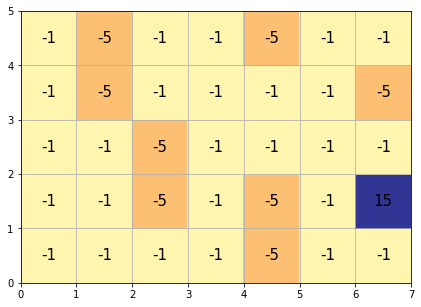

In [177]:
v = np.abs(M).max()
fig = plt.figure(figsize=(7,5))
plt.pcolor(M.T, cmap=plt.cm.RdYlBu, vmin=-v, vmax=v)
plt.grid()
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        s = str(int(M[i,j])).zfill(2)
        plt.text(i+0.5, j+0.5, s, horizontalalignment='center',
                                verticalalignment='center', size=15)

### Game rules

1. Game starts at a random position on the board
2. The goal is to reach the blue position with maximum possible accumulated points
3. The player can move *UP*, *DOWN*, *LEFT*, or *RIGHT*; moves off the board are not allowed
4. In each new position, the player receives a penalty (-1 or -5) or a reward (+15), as indicating in the plot above


## Q-Learning

$a \in A$, $s \in S$


$A=\left\{ a_1, a_2, \dots  \right\}$


tuple $\langle s,a,r,s' \rangle$
- current state $s$
- action $a$
- reward $r$
- future state $s'$


  
Belmann equation:
$$Q^{(i+1)}[s,a] = (1-\alpha)\,Q^{(i)}[s,a] + \alpha \left( r + \gamma \,Q^{(i)}\left[s,\text{argmax}_{a} \,Q^{(i)}[s,a]\right] \right)$$

- learning rate $\alpha$
- iteration index $i$
- discount rate $\gamma$


### Optimal policy

$$\pi_*(s) = \text{argmax}_{a} \,Q^{(i)}[s,a] $$

# ------------------------

In [321]:
class QLearnAgent:
    
    def __init__(self, maze_matrix, action_array, r_goal):
       
        self.maze = maze_matrix
        S, R, m = self.__transform_maze_matrix(maze_matrix)
        self.S = S
        self.R = R
        self.m = m
        self.A = self.__validate_actions(self.S, action_array)
       
        self.r_goal = r_goal
        
            
    def __transform_maze_matrix(self, maze_matrix):
        """
        Utility to transform matrix into S and R.
        """
        nx, ny = maze_matrix.shape
        m = 10**int(np.ceil(np.log10(ny)))

        S = []
        R = []

        for i in range(nx):
            for j in range(ny):
                state = maze_matrix[i,j]
                R.append(state)
                S.append(m*j + i)

        S = np.array(S).astype(int)
        R = np.array(R).astype(float)
        
        return S, R, m

    def __validate_actions(self, S, A):

        S = np.asarray(S)
        A = np.asarray(A)

        na = len(A)
        ns = len(S)

        A1 = np.zeros([ns, na])

        for i,s in enumerate(S):
            for j,a in enumerate(A):
                s1 = self.action(s, a)
                if s1 in S:
                    A1[i,j] = A[j]
                else:
                    A1[i,j] = np.nan

        A1 = np.ma.masked_invalid(A1).astype(int)
        return A1    

    def __xyflat_to_xypairs(self, xyflat, m=10):
        xyflat = np.array(xyflat)
        y = xyflat // m
        x = np.mod(xyflat, m)
        return x, y    
    
    def action(self, s, a):
        return s + a    
    
    def train(self, nmax_episodes=100, alpha=0.3, gamma=0.6, Q_init=None,
              l1=100, l2=40, pmax=0.3, pmin=0.02, random_state=666):
        
        self.nmax_episodes = nmax_episodes
        self.alpha = alpha
        self.gamma = gamma
        
        assert pmax <= 1., '0 <= pmin < pmax <= 1'
        assert pmin < pmax, '0 <= pmin < pmax <= 1'
        assert pmin >= 0., '0 <= pmin < pmax <= 1'
        
        if Q_init is None:
            np.random.seed(random_state)
            self.Q = np.random.rand(self.A.shape[0], self.A.shape[1])
        else:
            assert np.shape(Q_init) == (self.A.shape[0], self.A.shape[1]), 'Q shape must be "(len(S), len(A))"'
            self.Q = np.array(Q_init)

        self.Q = np.ma.masked_where(self.A.mask, self.Q)
        self.Q_init = self.Q.copy()       
        self.err_q = np.zeros(self.nmax_episodes)
       
        self.n_iter = 0
        self.n_steps = 0
        self.n_episodes = 0
        self.s = np.random.permutation(self.S).take(0)
        
        while self.n_episodes < self.nmax_episodes:
            
            # index of the current state
            i_s = np.where(self.S==self.s)[0].take(0)
    
            # random exploration/exploitation
            #pmax, pmin, l1, l2
            eps1 = np.clip( pmax * np.exp(-self.n_episodes / l1), pmin, 1. )
            eps2 = np.clip( pmax * (1. - np.exp(-(self.n_steps / l2))), pmin, 1. )
            
            if np.random.rand() < max(eps1, eps2):
                a = np.random.permutation(self.A[i_s][self.A[i_s].mask == False])[0].take(0)
                i_a = np.where(self.A[i_s] == a)[0].take(0)              
                #print('random', eps1, eps2, self.n_steps)

            else:
                i_a = np.argmax(self.Q[i_s,:]).take(0)
                a = self.A[i_s, i_a].take(0)

            # imediate reward for taking action a at state s
            r = self.R[i_s]
            
            self.n_steps += 1
            self.n_iter += 1
            
            if r == self.r_goal:
                
                self.err_q[self.n_episodes] = np.sum((self.Q_init - self.Q)**2)
                # estimate the thorugh Q_star instead
                
                self.n_episodes += 1
                self.n_steps = 0
                self.s = np.random.permutation(self.S).take(0)
                
                
            else:
                # the new state after taking action a at state s
                s1 = self.action(self.s, a)

                # future reward
                i_s1 = np.where(self.S==s1)[0].take(0)
                i_a1 = np.asarray(np.argmax(self.Q[i_s1,:])).take(0)

                # updating the Q table
                self.Q[i_s,i_a] = (1.-self.alpha)*self.Q[i_s,i_a] + self.alpha*(r + self.gamma*self.Q[i_s1,i_a1])

                # saving the new state
                self.s = s1
                
            
        self.Q_star = np.argmax(self.Q, axis=1)
        self.A_star = np.array([self.A[i,iq] for (i,iq) in enumerate(self.Q_star)]).astype(int)        
        self.err_q = self.err_q[0] / agent.err_q
        
    def play(self, s, max_episodes=100, verbose=True):
        
        i_s = np.where(self.S == s)[0].take(0) # 0
        
        #a = self.A[self.Q_star[i_s]]
        a = self.A_star[i_s]
        r = self.R[i_s]
        
        slist = []
        alist = []
        rlist = []
        
        slist.append(s)
        alist.append(a)
        rlist.append(r)

        i = 0
        if verbose:
            print('i: {:03d}, s: {:02d}, a: {:02d}, r: {:5.1f}, i_s: {:03d}'.format(i, s, a, r, i_s))
        
        while r != self.r_goal and i < max_episodes:
            
            s = self.action(s, a)
            
            i_s = np.where(self.S == s)[0].take(0)
            
            #a = self.A[self.Q_star[i_s]]
            a = self.A_star[i_s]
            r = self.R[i_s]
                   
            slist.append(s)
            alist.append(a)
            rlist.append(r)
            
            i += 1
            if verbose:           
                print('i: {:03d}, s: {:02d}, a: {:02d}, r: {:5.1f}, i_s: {:03d}'.format(i, s, a, r, i_s))
            
        s_arr = np.array(slist)
        a_arr = np.array(alist)
        r_arr = np.array(rlist)
        
        if verbose:
            print('\n  Total points: {}\n'.format(r_arr.sum()))
        
        return s_arr, a_arr, r_arr
    
    def plot(self, s, max_episodes=100, verbose=False):
        
        s_arr, a_arr, r_arr = self.play(s, max_episodes, verbose=verbose)
        x, y = self.__xyflat_to_xypairs(xyflat=s_arr, m=self.m)
        
        vmax = np.abs(self.R).max()
        vmin = -vmax

        plt.clf()
        plt.pcolor(self.maze.T, cmap=plt.cm.RdYlBu, vmin=vmin, vmax=vmax)
        plt.grid()
        plt.plot(x[:]+0.5, y[:]+0.5, 'k-o')
        plt.plot(x[0]+0.5, y[0]+0.5, 'r*', ms=16)
        plt.plot(x[-1]+0.5, y[-1]+0.5, 'ro', ms=12)
        plt.show()
    
    def multi_plot(self, slist, basename='_fig'):

        vmax = np.abs(self.R).max()
        vmin = -vmax

        ls = int(1 + np.ceil(np.log10(self.maze.shape[0] * self.maze.shape[1])))
        le = int(np.ceil(np.log10(len(slist))))

        for k, s in enumerate(slist):

            s_arr, a_arr, r_arr = self.play(s, verbose=False)
            x, y = self.__xyflat_to_xypairs(xyflat=s_arr, m=self.m)

            ns = len(s_arr)

            episode = str(k+1).zfill(le)

            fig = plt.figure()

            for j in range(1, ns+1):

                step = str(j).zfill(ls)

                fname = '{}_episode{}_step{}.png'.format(basename, episode, step)
                print(fname)

                fig.clf()            
                ax = fig.add_subplot(111)
                ax.pcolor(self.maze.T, cmap=plt.cm.RdYlBu, vmin=vmin, vmax=vmax)
                ax.plot(x[:j]+0.5, y[:j]+0.5, 'k-o')        
                ax.plot(x[0]+0.5, y[0]+0.5, 'k*', ms=15)

                if j == ns:  
                    ax.plot(x[-1]+0.5, y[-1]+0.5, 'kH', ms=15)

                ax.grid()

                fig.savefig(fname, dpi=100, bbox_inches='tight')

            plt.close('all')    

In [21]:
maze_matrix = maze.maze_7x5()

In [297]:
#plt.savefig?

In [186]:
action_array = np.array([-1, 1, 10, -10], dtype=int) # left, right, up, down
r_goal = maze_matrix.max()

In [298]:
agent = QLearnAgent(maze_matrix, action_array, r_goal)

In [299]:
agent.train(nmax_episodes=500, alpha=0.2, gamma=0.7)

In [285]:
#agent.plot(11, verbose=1)
#plt.plot?

In [300]:
agent.multi_plot(slist=[42], basename='_fig')

_fig_episode1_step001.png
_fig_episode1_step002.png
_fig_episode1_step003.png
_fig_episode1_step004.png
_fig_episode1_step005.png
_fig_episode1_step006.png
_fig_episode1_step007.png
_fig_episode1_step008.png


In [232]:
agent.n

0

In [64]:
agent.train(nmax_episodes=500, alpha=0.2, gamma=0.7, Q_init=Q_init)

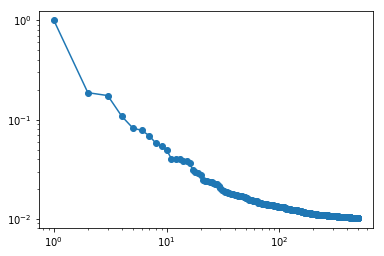

In [65]:
#plt.loglog(np.arange(agent.n_episodes)+1, agent.err_q[0]/agent.err_q, '-o')
plt.loglog(np.arange(agent.n_episodes)+1, agent.err_q, '-o')

In [247]:
10 ** int(np.ceil(np.log10(agent.maze.shape[0] * agent.maze.shape[1])))

100

## Animation

In [271]:
def multi_qplot(slist, agent, basename='_fig'):
       
    vmax = np.abs(agent.R).max()
    vmin = -vmax
    
    ls = int(1 + np.ceil(np.log10(agent.maze.shape[0] * agent.maze.shape[1])))
    le = int(np.ceil(np.log10(len(slist))))
        
    for k, s in enumerate(slist):
        
        s_arr, a_arr, r_arr = agent.play(s, verbose=False)
        x, y = agent.xyflat_to_xypairs(xyflat=s_arr, m=agent.m)
        
        ns = len(s_arr)
        
        episode = str(k+1).zfill(le)
        
        fig = plt.figure()
        
        for j in range(1, ns+1):
            
            step = str(j).zfill(ls)
            
            fname = '{}_episode{}_step{}.png'.format(basename, episode, step)
            print(fname)
                           
            fig.clf()            
            ax = fig.add_subplot(111)
            ax.pcolor(agent.maze.T, cmap=plt.cm.RdYlBu, vmin=vmin, vmax=vmax)
            ax.plot(x[:j]+0.5, y[:j]+0.5, 'k-o')        
            ax.plot(x[0]+0.5, y[0]+0.5, 'k*', ms=15)
            
            if j == ns:  
                ax.plot(x[-1]+0.5, y[-1]+0.5, 'kH', ms=15)
        
            ax.grid()
            
            fig.tight_layout()
            fig.savefig(fname, dpi=100)
            
        plt.close('all')

# ------------------

In [269]:
multi_qplot(slist=[0, 42], agent=agent, basename='_fig')

/home/guilherme/bin/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:149: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


IndexError: cannot do a non-empty take from an empty axes.

In [60]:
agent.play(40)

i: 000, s: 40, a: -10, r:  -1.0, i_s: 004
i: 001, s: 30, a: -10, r:  -1.0, i_s: 003
i: 002, s: 20, a: 01, r:  -1.0, i_s: 002
i: 003, s: 21, a: -10, r:  -1.0, i_s: 007
i: 004, s: 11, a: -10, r:  -1.0, i_s: 006
i: 005, s: 01, a: 01, r:  -1.0, i_s: 005
i: 006, s: 02, a: 01, r:  -1.0, i_s: 010
i: 007, s: 03, a: 10, r:  -1.0, i_s: 015
i: 008, s: 13, a: 10, r:  -1.0, i_s: 016
i: 009, s: 23, a: 01, r:  -1.0, i_s: 017
i: 010, s: 24, a: 01, r:  -1.0, i_s: 022
i: 011, s: 25, a: 01, r:  -1.0, i_s: 027
i: 012, s: 26, a: -10, r:  -1.0, i_s: 032
i: 013, s: 16, a: -1, r:  15.0, i_s: 031


(array([40, 30, 20, 21, 11,  1,  2,  3, 13, 23, 24, 25, 26, 16]),
 array([-10, -10,   1, -10, -10,   1,   1,  10,  10,   1,   1,   1, -10,
         -1]),
 array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        15.]))

# ------------------------

## Implementation

Flattening arrays

In [17]:
nx, ny = M.shape
m = 10**int(np.ceil(np.log10(ny)))

S = []
R = []

for i in range(nx):
    for j in range(ny):
        state = M[i,j]
        R.append(state)
        S.append(m*j + i)

S = np.array(S).astype(int)
R = np.array(R).astype(float)

In [6]:
# actions
A = np.array([-1,1,10,-10], dtype=int) # left, right, up, down

In [7]:
def action(s, a):
    return s + a

Invalidating actions that lead off the board

In [8]:
def valid_actions(S, A):
    
    S = np.asarray(S)
    A = np.asarray(A)
    
    na = len(A)
    ns = len(S)
    
    A1 = np.zeros([ns, na])
    
    for i,s in enumerate(S):
        for j,a in enumerate(A):
            s1 = action(s, a)
            if s1 in S:
                A1[i,j] = A[j]
            else:
                A1[i,j] = np.nan

    A1 = np.ma.masked_invalid(A1).astype(int)
    return A1

### Random initialization for Q

In [54]:
ns = len(S)
na = len(A)
Q = np.random.rand(ns, na)

# masked invalid
A1 = valid_actions(S, A)
Q1 = np.ma.masked_where(A1.mask, Q)

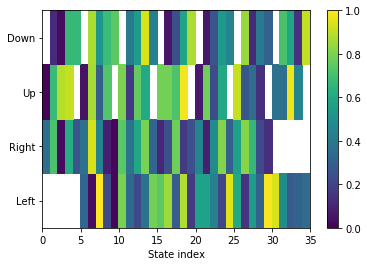

In [47]:
plt.pcolor(Q1.T, vmin=0.0, vmax=1.0)
plt.yticks([0.5, 1.5, 2.5, 3.5], ['Left', 'Right', 'Up', 'Down'])
plt.xlabel('State index')
plt.colorbar()

### Exploration

In [11]:
def epsilon(x, eps_0=0.3, eps_decay=100., eps_min=0.01):
    
    epsilon = eps_0 * np.exp(-x / eps_decay)
                             
    if epsilon < eps_min:
        epsilon = 0.0
    
    return epsilon

In [142]:
#
alpha = 0.1 #0.3
gamma = 0.8 #0.2

# inital state
s = 0

#
r_goal = 15.

#
n_games_max = 2000
n_iter = 0
n_steps = 0
n_games = 0

points = np.zeros(n_games_max, dtype=float)
game_rewards = 0
#
msg = 'games: {:4d}, iter: {:5d}, steps: {:3d}, state: {:2d}, action {:3d}, game_rewards: {:3.2f}'

np.random.seed(666)

In [ ]:
while n_games < n_games_max:
    
    # current state
    i_s = np.where(S==s)[0].take(0)
    
    # random exploration
    #eps1 = 0. #epsilon(n_games, eps_0=0.03, eps_decay=100., eps_min=0.01)
    eps2 = 0.2 * (1. -np.exp(-(n_steps/20.)))
    #eps2 = 0. #0.03 - epsilon(n_steps, eps_0=0.03, eps_decay=10., eps_min=0.0)
    
    #if np.random.rand() < 0.1: #max(eps1, eps2):
    if np.random.rand() < eps2:
    #if np.mod(n_steps, 50) == 0:
        a = np.random.permutation(A1[i_s][A1[i_s].mask == False])[0].take(0)
        #n_steps = 0
        #print('random, steps: {:5d}, eps: {:5.2}'.format(n_steps, a+0.))

    else:
        i_a = np.argmax(Q1[i_s,:]).take(0)
        a = A1[i_s, i_a].take(0)    # best action to take 
        #print(' -- ', 'Qtable', a, i_a, i_s)
    
    
    r = R[i_s]     # imediate reward of taking action a at state s
    
    #print('r ', r, 's ', s, 'a ', a)
    game_rewards += r
    
    s1 = action(s, a) # the new state after taking action a at state s
    
    # future reward
    i_s1 = np.where(S==s1)[0].take(0)
    i_a1 = np.asarray(np.argmax(Q1[i_s1,:])).take(0)
    
   
    # updating the Q table
    Q1[i_s,i_a] = (1.-alpha)*Q1[i_s,i_a] + alpha*(r + gamma*Q1[i_s1,i_a1])
   
    s = s1 # saving state for next iteration
    
    n_iter += 1
    n_steps += 1
    
    #if np.mod(n_iter, 50) == 0:
     #   print(n_games, n_iter, n_steps, eps1, eps2, s, a)
    
    if r == r_goal:
        points[n_games] = r #np.cumsum(points[:n_games]) 
        if np.mod(n_games, 50) == 0.:
            print(msg.format(n_games, n_iter, n_steps, s, a, game_rewards))
        
        n_games += 1
        n_steps = 0
        game_rewards = 0
        
        # starting from a random new state
        idx = np.random.randint(low=0, high=len(S), size=1)[0]
        s = S[idx]
    

In [144]:
Qstar = np.argmax(Q1, axis=1)

In [123]:
#Q2 = (Q1/Q1.max(axis=0))
#Q2 = (Q1.T/Q1.max(axis=1)).T
#Q1.max(axis=0).shape

In [27]:
#n_games, eps1, eps2
#plt.plot(np.cumsum(points))
game_rewards

0

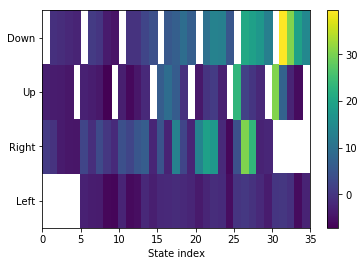

In [145]:
plt.clf()
plt.pcolor(Q1.T)
plt.yticks([0.5, 1.5, 2.5, 3.5], ['Left', 'Right', 'Up', 'Down'])
plt.xlabel('State index')
plt.colorbar()

In [29]:
def xyflat_to_xypairs(xyflat, m=10):
    xyflat = np.array(xyflat)
    y = xyflat // m
    x = np.mod(xyflat, m)
    return x, y

In [83]:
def qplay(s, S, A, R, Qstar, r_goal):

    xyflat = []

    xyflat.append(s)

    for _ in range(20):
        s0 = s
        ix = np.where(S == s0)[0][0]
        iy = Qstar[ix]
        a = A[iy]
        #
        r = R[ix]
        s1 = action(s, a)
        print(s, a, r)
        xyflat.append(s)
        s = s1

        if r == r_goal:
            x, y = xyflat_to_xypairs(xyflat)
            return x, y
            
            #break
        
    #x, y = xyflat_to_xypairs(xyflat)
    #return x, y

In [137]:
#plt.plot?

In [138]:
def qplot(s, M, S, A, R, Qstar, r_goal):
    
    x, y = qplay(s, S, A, R, Qstar, r_goal)
    
    plt.clf()
    plt.pcolor(M.T, cmap=plt.cm.RdYlBu, vmin=-10, vmax=10)
    plt.grid()
    plt.plot(x[:]+0.5, y[:]+0.5, 'k-o')
    plt.plot(x[0]+0.5, y[0]+0.5, 'k-*', ms=4)
    plt.plot(x[0]+0.5, y[0]+0.5, 'k-x', ms=4)

40 -10 -1.0
30 -10 -1.0
20 -10 -1.0
10 1 -1.0
11 -10 -1.0
1 1 -1.0
2 1 -1.0
3 10 -1.0
13 10 -1.0
23 1 -1.0
24 1 -1.0
25 1 -1.0
26 -10 -1.0
16 -10 15.0


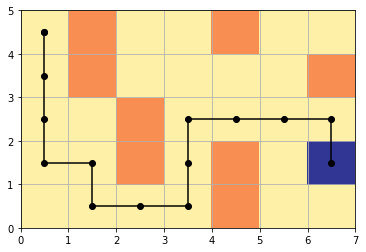

In [148]:
qplot(40, M, S, A, R, Qstar, r_goal)

In [313]:
 def play(self, s, max_episodes=100):
        
        i_s = np.where(self.S == s)[0].take(0) # 0
        
        #a = self.A[self.Q_star[i_s]]
        a = self.A_star[i_s]
        r = self.R[i_s]
        
        slist = []
        alist = []
        rlist = []
        
        slist.append(s)
        alist.append(a)
        rlist.append(r)

        i = 0        
        print('i: {:03d}, s: {:02d}, a: {:02d}, r: {:5.1f}, i_s: {:03d}'.format(i, s, a, r, i_s))
        
        while r != self.r_goal and i < max_episodes:
            
            s = self.action(s, a)
            
            i_s = np.where(self.S == s)[0].take(0)
            
            #a = self.A[self.Q_star[i_s]]
            a = self.A_star[i_s]
            r = self.R[i_s]
                   
            slist.append(s)
            alist.append(a)
            rlist.append(r)
            
            i += 1
            print('i: {:03d}, s: {:02d}, a: {:02d}, r: {:5.1f}, i_s: {:03d}'.format(i, s, a, r, i_s))
            
        s_arr = np.array(slist)
        a_arr = np.array(alist)
        r_arr = np.array(rlist)
        
        return s_arr, a_arr, r_arr

## Classy implementation

In [334]:
import numpy as np
import matplotlib.pyplot as plt
import maze

In [7]:
class QLearnAgent:
    
    def __init__(self, maze_matrix, action_array, r_goal):
       
        self.maze = maze_matrix
        S, R = self.__transform_maze_matrix(maze_matrix)
        self.S = S
        self.R = R
        self.A = self.__validate_actions(self.S, action_array)
       
        self.r_goal = r_goal
        
            
    def __transform_maze_matrix(self, maze_matrix):
        """
        Utility to transform matrix into S and R.
        """
        nx, ny = maze_matrix.shape
        m = 10**int(np.ceil(np.log10(ny)))

        S = []
        R = []

        for i in range(nx):
            for j in range(ny):
                state = maze_matrix[i,j]
                R.append(state)
                S.append(m*j + i)

        S = np.array(S).astype(int)
        R = np.array(R).astype(float)
        
        return S, R        

    def __validate_actions(self, S, A):

        S = np.asarray(S)
        A = np.asarray(A)

        na = len(A)
        ns = len(S)

        A1 = np.zeros([ns, na])

        for i,s in enumerate(S):
            for j,a in enumerate(A):
                s1 = self.action(s, a)
                if s1 in S:
                    A1[i,j] = A[j]
                else:
                    A1[i,j] = np.nan

        A1 = np.ma.masked_invalid(A1).astype(int)
        return A1    

    def action(self, s, a):
        return s + a    
    
    def train(self, nmax_episodes=100, alpha=0.3, gamma=0.6, Qinit=None, random_state=666):
        
        self.nmax_episodes = nmax_episodes
        self.alpha = alpha
        self.gamma = gamma
        
        if Qinit is None:
            np.random.seed(random_state)
            self.Q = np.random.rand(self.A.shape[0], self.A.shape[1])
        else:
            assert np.shape(Qinit) == (self.A.shape[0], self.A.shape[1]), 'Q shape must be "(len(S), len(A))"'
            self.Q = np.array(Qinit)

        self.Q = np.ma.masked_where(self.A.mask, self.Q)
        self.Q_init = self.Q.copy()       
        self.err_q = np.zeros(self.nmax_episodes)
       
        self.n_iter = 0
        self.n_steps = 0
        self.n_episodes = 0
        self.s = np.random.permutation(self.S).take(0)
        
        while self.n_episodes < self.nmax_episodes:
            
            # index of the current state
            i_s = np.where(self.S==self.s)[0].take(0)
    
            # random exploration
            eps1 = np.clip( 0.3 * np.exp(-self.n_episodes / 500.), 0.02, 1. )
            eps2 = np.clip( 0.3 * (1. - np.exp(-(self.n_steps/40.))), 0.02, 1. )
            
            if np.random.rand() < max(eps1, eps2):
                a = np.random.permutation(self.A[i_s][self.A[i_s].mask == False])[0].take(0)
                i_a = np.where(self.A[i_s] == a)[0].take(0)              
                #print('random', eps1, eps2, self.n_steps)

            else:
                i_a = np.argmax(self.Q[i_s,:]).take(0)
                a = self.A[i_s, i_a].take(0)

            # imediate reward for taking action a at state s
            r = self.R[i_s]
            
            self.n_steps += 1
            self.n_iter += 1
            
            if r == self.r_goal:
                
                self.err_q[self.n_episodes] = np.sum((self.Q_init - self.Q)**2)
                # estimate the thorugh Q_star instead
                
                self.n_episodes += 1
                self.n_steps = 0
                self.s = np.random.permutation(self.S).take(0)
                
                
            else:
                # the new state after taking action a at state s
                s1 = self.action(self.s, a)

                # future reward
                i_s1 = np.where(self.S==s1)[0].take(0)
                i_a1 = np.asarray(np.argmax(self.Q[i_s1,:])).take(0)

                # updating the Q table
                self.Q[i_s,i_a] = (1.-self.alpha)*self.Q[i_s,i_a] + self.alpha*(r + self.gamma*self.Q[i_s1,i_a1])

                # saving the new state
                self.s = s1
                
            
        self.Q_star = np.argmax(self.Q, axis=1)
        self.A_star = np.array([agent.A[i,iq] for (i,iq) in enumerate(agent.Q_star)]).astype(int)
        
    def play(self, s, max_episodes=100):
        
        i_s = np.where(self.S == s)[0].take(0) # 0
        
        #a = self.A[self.Q_star[i_s]]
        a = self.A_star[i_s]
        r = self.R[i_s]
        
        slist = []
        alist = []
        rlist = []
        
        slist.append(s)
        alist.append(a)
        rlist.append(r)

        i = 0        
        print('i: {:03d}, s: {:02d}, a: {:02d}, r: {:5.1f}, i_s: {:03d}'.format(i, s, a, r, i_s))
        
        while r != self.r_goal and i < max_episodes:
            
            s = self.action(s, a)
            
            i_s = np.where(self.S == s)[0].take(0)
            
            #a = self.A[self.Q_star[i_s]]
            a = self.A_star[i_s]
            r = self.R[i_s]
                   
            slist.append(s)
            alist.append(a)
            rlist.append(r)
            
            i += 1
            print('i: {:03d}, s: {:02d}, a: {:02d}, r: {:5.1f}, i_s: {:03d}'.format(i, s, a, r, i_s))
            
        s_arr = np.array(slist)
        a_arr = np.array(alist)
        r_arr = np.array(rlist)
        
        return s_arr, a_arr, r_arr
    
    def plot(self, s, max_episodes=100):
        pass
        #s_arr, a_arr, r_arr = self.play(s, max_episodes=100)
        # x, y = qplay(s)
        #plt.clf()
        #plt.pcolor(M.T, cmap=cm.RdYlBu, vmin=-10, vmax=10)
        #plt.grid()
        #plt.plot(x[:]+0.5, y[:]+0.5, 'k-o')
    

In [8]:
maze_matrix = maze.maze_7x5()
action_array = np.array([-1, 1, 10, -10], dtype=int) # left, right, up, down
r_goal = 15.
#
agent = QLearnAgent(maze_matrix, action_array, r_goal)

In [9]:
agent.train(nmax_episodes=1000, alpha=0.2, gamma=0.7)

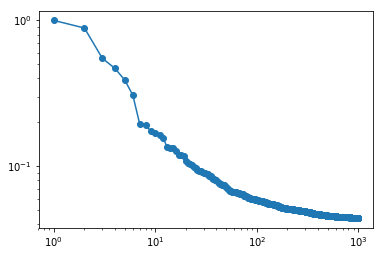

In [10]:
plt.loglog(np.arange(agent.n_episodes)+1, agent.err_q[0]/agent.err_q, '-o')

In [6]:
# loading the maze
M = maze.maze_7x5()

In [101]:
nx, ny = M.shape
m = 10**int(np.ceil(np.log10(ny)))

S = []
R = []

for i in range(nx):
    for j in range(ny):
        state = M[i,j]
        R.append(state)
        S.append(m*j + i)

S = np.array(S).astype(int)
R = np.array(R).astype(float)

In [8]:
# actions
A = np.array([-1,1,10,-10], dtype=int) # left, right, up, down

In [15]:
def action(s, a):
    return s + a

In [102]:
def valid_actions(S, A):
    
    S = np.asarray(S)
    A = np.asarray(A)
    
    na = len(A)
    ns = len(S)
    
    A1 = np.zeros([ns, na])
    
    for i,s in enumerate(S):
        for j,a in enumerate(A):
            s1 = action(s, a)
            if s1 in S:
                A1[i,j] = A[j]
            else:
                A1[i,j] = np.nan

    A1 = np.ma.masked_invalid(A1).astype(int)
    return A1

In [180]:
ns = len(S)
na = len(A)
Q = np.random.rand(ns, na)

# masked invalid
A1 = valid_actions(S, A)
Q1 = np.ma.masked_where(A1.mask, Q)

r_goal= 15.

In [241]:
agent = QLearnAgent(nmax_episodes=50, alpha=0.3, gamma=0.6)

In [242]:
agent.S = S
agent.R = R
agent.Q = Q1
agent.A = A1
#agent.Q_star = Qstar
agent.r_goal = r_goal

In [540]:
agent.train()

In [133]:
#np.where(agent.S == 8)[0].take(0)
agent.S

array([ 0, 10, 20, 30, 40,  1, 11, 21, 31, 41,  2, 12, 22, 32, 42,  3, 13,
       23, 33, 43,  4, 14, 24, 34, 44,  5, 15, 25, 35, 45,  6, 16, 26, 36,
       46])

In [106]:
#agent.train()
agent.nmax_episodes, agent.alpha, agent.gamma

(100, 0.3, 0.6)

In [155]:
#agent.A_star = [agent.A[]
#agent.A_star = [agent.A[i,iq] for (i,iq) in enumerate(agent.Q_star)]

In [245]:
#agent.Q_star
#agent.A_star
agent.play(0, 100)

i: 000, s: 00, a: 01, r:  -1.0, i_s: 000
i: 001, s: 01, a: 01, r:  -1.0, i_s: 005
i: 002, s: 02, a: 01, r:  -1.0, i_s: 010
i: 003, s: 03, a: 10, r:  -1.0, i_s: 015
i: 004, s: 13, a: 01, r:  -1.0, i_s: 016
i: 005, s: 14, a: 01, r:  -5.0, i_s: 021
i: 006, s: 15, a: 01, r:  -1.0, i_s: 026
i: 007, s: 16, a: -1, r:  15.0, i_s: 031


(array([ 0,  1,  2,  3, 13, 14, 15, 16]),
 array([ 1,  1,  1, 10,  1,  1,  1, -1]),
 array([-1., -1., -1., -1., -1., -5., -1., 15.]))

# Results

![Example](game.gif)

# Finally

In [314]:
from qlearn_maze_agent import QLearnAgent

In [324]:
#from importlib import reload
#reload(QLearnAgent)

In [21]:
maze_matrix = maze.maze_7x5()

In [303]:
r_goal = maze_matrix.max()

In [311]:
action_array = np.array([-1, 1, 10, -10], dtype=int) # left, right, up, down

In [322]:
agent = QLearnAgent(maze_matrix, action_array, r_goal)

In [323]:
agent.train(nmax_episodes=500, alpha=0.2, gamma=0.7)

In [326]:
#agent.plot(11, verbose=1)
#plt.plot?

In [325]:
agent.multi_plot(slist=[42], basename='_fig')

_fig_episode1_step001.png
_fig_episode1_step002.png
_fig_episode1_step003.png
_fig_episode1_step004.png
_fig_episode1_step005.png
_fig_episode1_step006.png
_fig_episode1_step007.png
_fig_episode1_step008.png


## Q

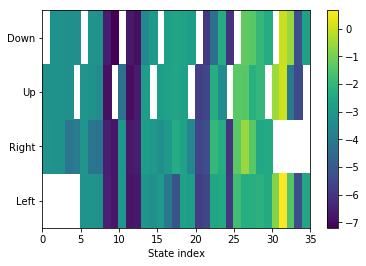

In [327]:
plt.clf()
plt.pcolor(agent.Q.T)
plt.yticks([0.5, 1.5, 2.5, 3.5], ['Left', 'Right', 'Up', 'Down'])
plt.xlabel('State index')
plt.colorbar()